# Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).

Your project is to:
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to
improve conversion rate

## Dataset

Columns:

country : user country based on the IP address

age : user age. Self-reported at sign-in step

new_user : whether the user created the account during this session or had already an
account and simply came back to the site

source : marketing channel source

Ads: came to the site by clicking on an advertisement
Seo: came to the site by clicking on search results
Direct: came to the site by directly typing the URL on the browser

total_pages_visited: number of total pages visited during the session. This is a proxy for
time spent on site and engagement during the session.

converted: this is our label. 1 means they converted within the session, 0 means they left
without buying anything. The company goal is to increase conversion rate: number of conversions
/ total sessions.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from my_utils import *

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import importlib

In [2]:
df = pd.read_csv('conversion_data.csv')
print(df.describe())
print('\n')
print(df.shape)
print(df.dtypes)
df.head()

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


(316200, 6)
country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
target = 'converted'

# Exploratory Data Analysis

In [4]:
numeric = df.select_dtypes(include=np.number).columns.tolist()
numeric.remove(target)
categoric = [col for col in df.columns if col not in numeric] + ['new_user']

Plot histogram for the numeric variables.

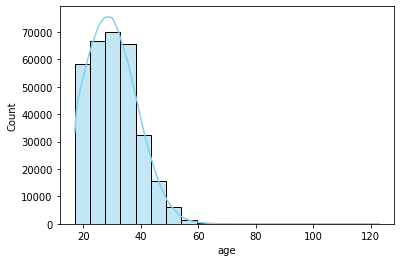

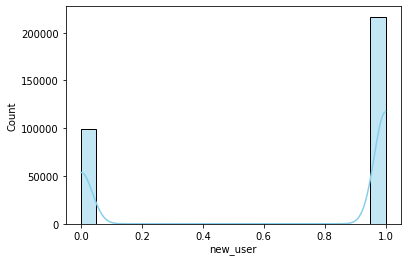

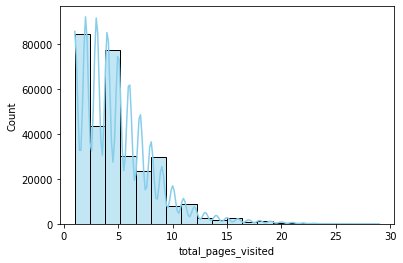

In [5]:
for col in numeric:
    sns.histplot(df[col], kde=True, bins=20,  color = "skyblue")
    plt.show()

Age and total_pages_visited are skewed, let's cap them to the range between 5 to 95 percentile.

In [6]:
for col in ["age", "total_pages_visited"]:
    mi = df[col].quantile(0.05)
    ma = df[col].quantile(0.95)
    df[col].clip(lower = mi, upper = ma, inplace=True)
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.371790,0.685465,4.712160,0.032258
std,7.724315,0.464331,2.865181,0.176685
min,18.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,45.000000,1.000000,11.000000,1.000000


Plot distribution for numeric variables VS target variable.

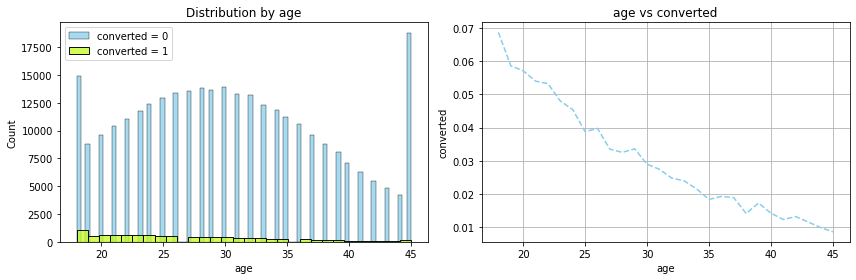

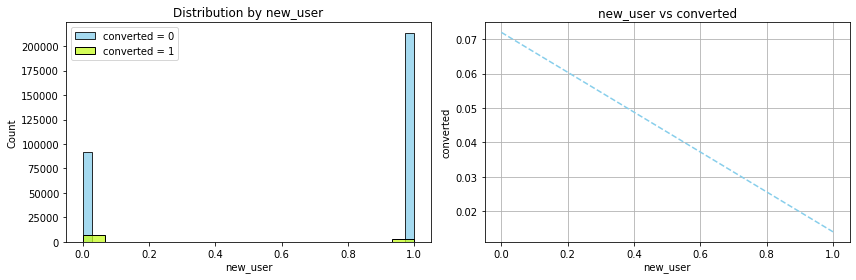

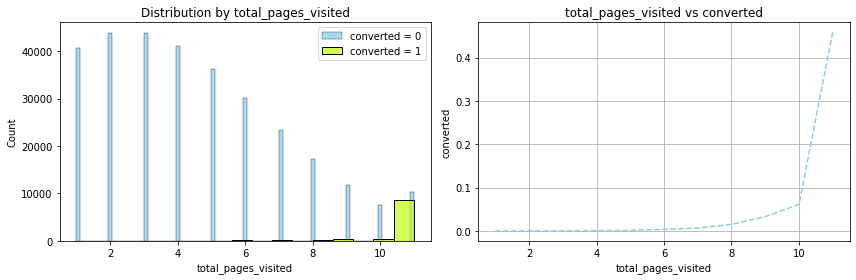

In [7]:
for col in numeric:
    # add count distribution
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
    sns.histplot(df[df[target] == 0][col], label='{} = 0'.format(target), ax=ax[0], color = 'skyblue' )
    sns.histplot(df[df[target] == 1][col], label='{} = 1'.format(target), ax=ax[0], color = "#c6fc21" )
    ax[0].set_title('Distribution by {}'.format(col), fontsize=12)
    ax[0].legend()
    # add line plot for variable VS target
    df_g = df.groupby(col, as_index=False).mean(target)
    ax[1].plot(df_g[col], df_g[target], linestyle='dashed', color = 'skyblue')
    ax[1].set_title('{} vs {}'.format(col, target),  fontsize=12)
    ax[1].set_xlabel('{}'.format(col))
    ax[1].set_ylabel('{}'.format(target))
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

Create bar plot for categorical variables.

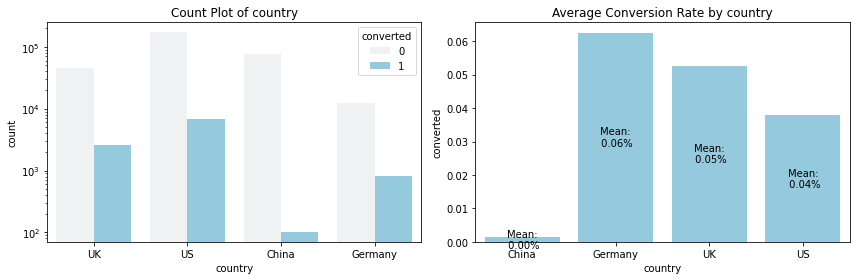

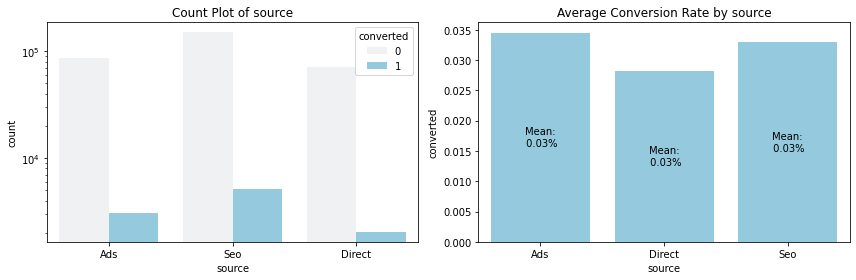

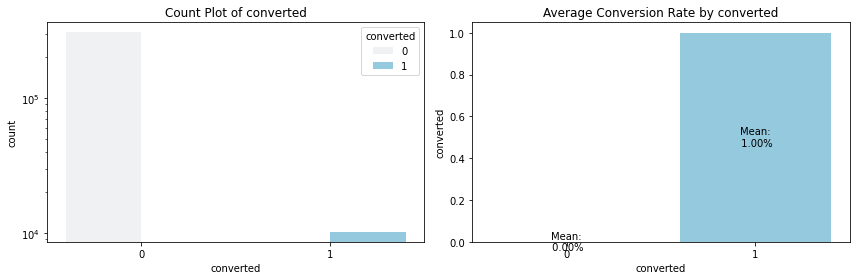

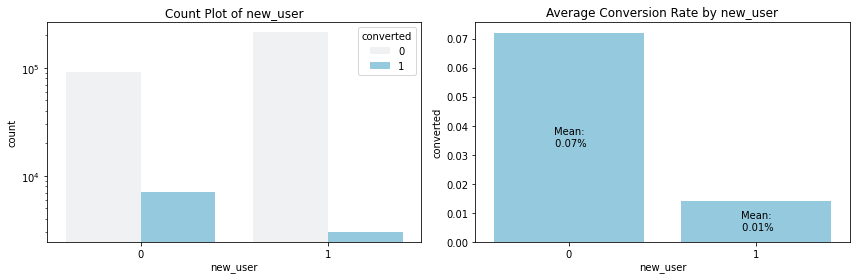

In [8]:
for col in categoric:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
    
    sns.countplot(x=col, hue= target, data=df, ax=ax[0], color = 'skyblue')
    ax[0].set_title('Count Plot of {}'.format(col), fontsize=12)
    ax[0].set_yscale('log')
    
    # aggregate data
    df_p = df.groupby(col, as_index=False).mean(target)
    # add the barplot
    sns.barplot(x = col, y = target, data = df_p, color='skyblue', ax=ax[1])
    # add annotation
    ax[1].bar_label(ax[1].containers[-1], fmt = 'Mean:\n %.2f%%', label_type='center')
    ax[1].set_title('Average Conversion Rate by {}'.format(col), fontsize=12) 

    plt.tight_layout()
    plt.show()

# Variable selection

Select the variables based on their information value.

In [9]:
dtrain, dtest = train_test_split(df, test_size= 0.25, random_state=7)

Drop variables that have more than 20% missing or variables with no variations.

In [10]:
column_check(dtrain)

No variable is dropped


['country', 'age', 'new_user', 'source', 'total_pages_visited', 'converted']

No severe collinearity is detected.

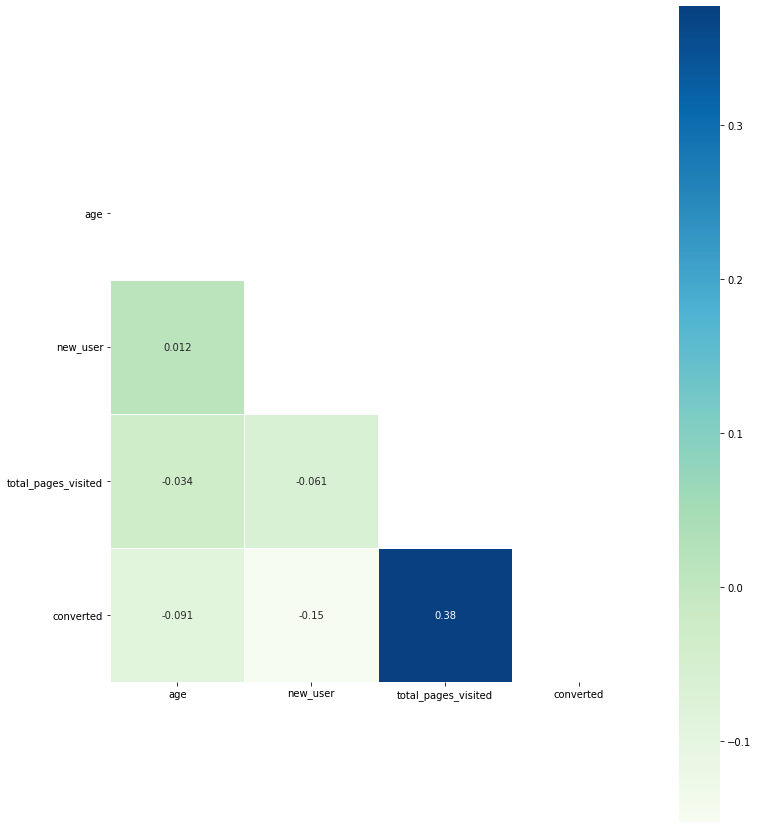

In [11]:
plot_correlation(dtrain)

No missing value.

In [156]:
dtrain.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

It seems that total pages vistited, country, new user and age has certain level of predicting power.

In [104]:
iv, woedf = iv_woe(dtrain, target )
variable_useful = iv[iv['IV']>=0.02].sort_values(by = 'IV', ascending=False)
name_list = variable_useful['Variable'].tolist()
variable_useful

,Variable,IV
0,total_pages_visited,5.869765
0,country,0.860891
0,new_user,0.681220
0,age,0.291882


In [109]:
# Standardize the numeric variables and encode the categorical variables
mapper = DataFrameMapper([('country', LabelBinarizer()),
                           (['total_pages_visited'], StandardScaler()),
                           (['age'], StandardScaler()),
                           ('new_user', None)], df_out=True)

# Mdodeling
Build a baseline model using logistic regression.

In [105]:
y_train = dtrain[target]
x_train = dtrain.drop(columns = [target, 'source'])

y_test = dtest[target]
x_test = dtest.drop(columns = [target, 'source'])

In [106]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, dtrain.shape, dtest.shape

((237150, 4), (237150,), (79050, 4), (79050,), (237150, 6), (79050, 6))

In [107]:
x_train.head()

,country,age,new_user,total_pages_visited
242671,US,31,1,5
57370,China,38,1,7
183396,UK,37,0,4
106851,China,39,1,5
86565,US,37,1,11


In [110]:
mapper_fit = mapper.fit(x_train)

In [111]:
x_train = mapper_fit.transform(x_train)
x_test = mapper_fit.transform(x_test)

In [112]:
cv = StratifiedKFold(n_splits =10, shuffle = True, random_state =7)
clf = LogisticRegression(class_weight = 'balanced')
auc_score = make_scorer(roc_auc_score)

Logistic regression already provides a pretty good performance so not very neccesary to try other modeling methods, especially considering the model interpretability.

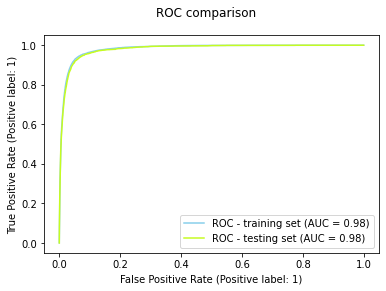

In [113]:
train_fit_model(clf, x_train, y_train, x_test, y_test)

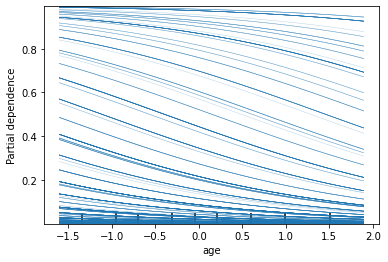

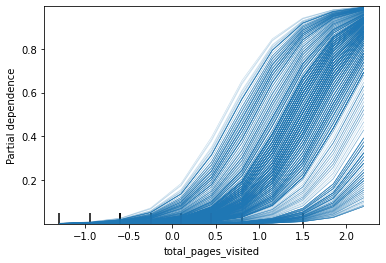

In [114]:
from sklearn.inspection import plot_partial_dependence
for col in ['age', 'total_pages_visited']:
    plot = plot_partial_dependence(clf, features = [col], X=x_train, kind='individual')
    plt.show()

In [115]:
# check the coefficients for each predictors
coef = pd.DataFrame({'Variable': x_train.columns.tolist(), 'Coefficient': clf.coef_[0]})
coef.sort_values(by='Coefficient', ascending = False, inplace = True)
coef

,Variable,Coefficient
4,total_pages_visited,3.041455
1,country_Germany,1.115933
2,country_UK,0.921483
3,country_US,0.608521
5,age,-0.573908
6,new_user,-1.713196
0,country_China,-2.650803


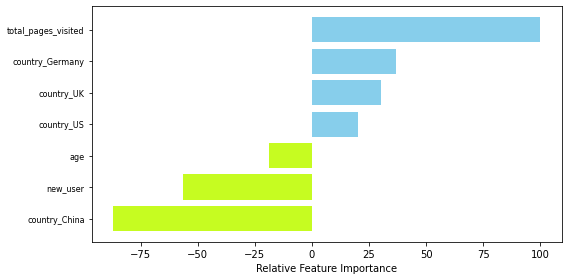

In [120]:
plot_feature_importance(clf, x_train)

Summary:
- Total pages vistited is the most importanct predictor that has positive impact on the conversion rate. 
The more pages the visitors visited the more likely they are going to convert. 
- Country is the second most important predictors. People from China are less likely to convert,
while people from UK and US are the most likely to convert.
- New users are less likely to convert compared with old users.
- Age of the users also have some negative impact on conversion rate.

Recommendations:
- Improve the website user experience, via improving the webpage loading time and reducing the steps that customers need to take before they convert
so that users can have a smooth and pleasant shopping experience.
- Tracking the users and using method like email/text notification if possible to remind users to come back to visit the websites. The more familar they 
are with the website, the more chances they are going to convert.
- In this analysis, we don't see source playing an important role. However, users from different country turn out to have different
level of conversion rate. We may need to consider spending more on marketing campaign on countries like Germany, UK and US. It may also worth a
further investigation on why users from China are less likely to convert considering China is one of the biggest markets in the world.
- Since younger people are more likely to convert, we want to keep improving the contents/product to attract more and more younger age users.